In [256]:
import pandas as pd
import numpy as np
from itertools import permutations
from itertools import combinations
from collections import Counter

In [257]:
tesis = pd.read_csv("./data_tesis.csv", low_memory=False)

In [258]:
marketing = pd.read_csv("./marketing.csv")
marketing = marketing.loc[:,["user_id","marketing_channel","converted"]]
marketing['converted'] = marketing['converted']*1
marketing = marketing.dropna()
marketing = marketing.sort_values(by=['user_id','marketing_channel'])

# GENERAL

In [259]:
def formatear(data):
    '''
    Toma el dataset (lista o dataframe), valida los tipos de datos y transforma el tipo y nombre de las columnas
    para optimizar el procesamiento
    '''
    
    # definir el nombre de las columnas
    columnas = ['usuario','canal','conversion']
    
    # formatear los datos segun el tipo
    if isinstance(data,list):
        data = pd.DataFrame(data,columns=columnas)
    if isinstance(data,pd.DataFrame):
        data.columns = columnas
    else:
        print("Error en el formato")
        
    # pasar usuario a numerico
    data['usuario'] = pd.factorize(data['usuario'])[0]
    
    return data


# MARKOV

In [260]:
def markov_chain(data, attributes = True):
    '''
    DESCRIPCION
    Toma un dataframe con recorridos de usuarios que pueden terminar o no en conversion.
    A partir de eso, calcula un modelo de markov de orden 1 para distribuir las conversiones entre los canales.
    
    PARAMETROS
    - attributes: True para retornar los valores absolutos de las conversiones
    
    RETURN
    - removal_effect: Un diccionario con los canales como keys y los valores como value segun los parametros.
    
    REQUERIMIENTOS
    - Tipo list o dataframe
    - Ordenado cronologicamente
    - 3 columnas en orden: usuario, canal y conversion (booleano)

    '''
    # validar input
    data = formatear(data)

    # obtener caminos formateados para Markov
    caminos = obtener_caminos_markov(data)
    
    # obtener matriz de transicion de probabilidades
    matriz = calcular_matriz_transicion(caminos)
    
    # obtener el diciconario del removal effect de cada canal
    removal_effect = calcular_removal_effect(matriz)
        
    # atribuir segun los parametros de la funcion
    if attributes:
        removal_effect.update((x, y*np.sum(data['conversion'].tolist())) for x, y in removal_effect.items())
    
    # redondear valores
    removal_effect = {k:round(v,4) for k,v in removal_effect.items()}
    
    # pasar a data frame
    atribucion = pd.DataFrame.from_dict(removal_effect,orient='index',columns=["markov"])
    
    return atribucion

In [261]:
def obtener_caminos_markov(data):
    '''
    Toma un dataframe de sesiones, agrupa por usuario y aplica una funcion
    para obtener los caminos de cada uno hasta la conversion incluyendo los que no convierten
    y sin eliminar canales repetidos.
    '''    
    def funcion_list_markov(data):
        '''
        Toma un data frame por usuario, crea contenedores y va iterando almacenando los canales 
        que llevan a la conversion, agregando al final los canales que llevan a la no conversion
        '''
        # crear contenedores
        final = []
        caminos = []

        # iterar sobre las sesiones
        for i in data.itertuples():
            caminos.append(i.canal)

            # si hay conversion, agregar los canales anteriores
            if i.conversion == 1:
                final.append([">".join(caminos),1])
                # resetear
                caminos = []
        # agregar canales sobrantes si los hay
        if len(caminos)>0:
            final.append([">".join(caminos),0])

        return final
    
    # aplicar la funcion a cada usuario
    caminos = data.groupby('usuario',observed=True).apply(funcion_list_markov).explode().tolist()
    
    return caminos

In [262]:
def calcular_matriz_transicion(data):
    '''
    Toma un dataset de caminos y lo convierte en una matriz de transiciones entre canales para calcular Markov.
    Incluye como canal (start) al inicio de cada recorrido y (null) o (conversion) segun el resultado.    
    '''
    
    # agregar estados iniciales y finales
    recorridos = ["(start)>"+i[0]+">(conversion)" if i[1] == 1 else "(start)>"+i[0]+">(null)" for i in data]
    
    # armar las transiciones con pares de canales
    transiciones = list(map(lambda x:list(zip(x[:],x[1:])),[i.split(">") for i in recorridos]))
    
    # darle formato de inicio y fin
    transiciones_formato = pd.DataFrame([j for i in transiciones for j in i],columns=['start','end'])
    
    # armar la matriz normalizada con las transiciones
    matriz = pd.crosstab(index=transiciones_formato['start'],columns=transiciones_formato['end'], normalize = 'index', dropna = False)
    
    # chequear si falta alguna columna y agregarla
    for columna in ['(conversion)','(null)']:
        if columna not in matriz.columns:
            matriz.insert(0,columna,np.zeros(matriz.shape[0]))
    
    # agregar start como posible final
    matriz.insert(0,'(start)',np.zeros(matriz.shape[0]))
    
    return matriz

In [263]:
def calcular_markov(data):
    '''
    Toma una matriz de transiciones entre los canales (con null, start y conversion) y devuelve la tasa de
    conversion partienda del estado start.
    '''
    # armar matriz de convergencia (columnas finales)
    removal_to_conv = data[['(null)','(conversion)']]
    
    # armar matriz de canales (filas de canales)
    removal_to_non_conv = data.drop(['(conversion)','(null)'],axis=1)
    
    # calcular la inversa de (I - canales)
    removal_inv_diff = np.linalg.inv(np.identity(len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
    
    # calcular producto matricial de la inversa y la de convergencia
    removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        
    # devolver la probabilidad de conversion del inicio en start
    cvr = pd.DataFrame(removal_dot_prod,index=removal_to_conv.index)[[1]].loc['(start)'].values[0]
    
    return cvr

In [264]:
def calcular_removal_effect(data):
    '''
    Toma una matriz de transiciones entre los canales (con null, start y conversion) y calcula el removal effect
    de cada uno de los canales.
    
    Para eso, itera sobre los canales (sin start, conversion y null) y calcula la tasa de conversion general. 
    Luego, borra la fila del canal, asigna sus probabilidades de transicion a null y recalcula la
    tasa de conversion.
    
    Devuelve la proporcion normalizada en que disminuye la tasa de conversion original.
    
    '''
    # calcular conversion general y guardar
    cr_general = calcular_markov(data)
    
    # crear un diccionario para almacenar removal effect de cada canal
    removal_effect = {}
    
    # iterar sobre canales validos
    for channel in data.columns:
        if channel not in ['(start)','(conversion)','(null)']:
            
            # borrar linea y columna del canal
            matriz_canal = data.drop(channel, axis=1).drop(channel, axis=0)
            
            # reasignar probabilidad a nulo
            for column in matriz_canal.columns:
                if column not in ['(conversion)','(null)']:
                    faltante = float(1) - np.sum(list(matriz_canal.loc[column]))
                    if faltante != 0:
                        matriz_canal.loc[column]['(null)'] = faltante
            
            # calcular la conversion
            cr_canal = calcular_markov(matriz_canal)
           
            # calcular la variacion de la conversion
            removal_effect_canal = 1 - cr_canal / cr_general
            
            # guardar en diccionario
            removal_effect[channel] = removal_effect_canal
    
    # calcular valor total
    suma = np.sum(list(removal_effect.values()))
    
    # normalizar
    removal_effect_normalizado = {key: (value / suma) for key, value in removal_effect.items()}

    # devolver diccionario
    return removal_effect_normalizado

# SHAPLEY

In [265]:
def shapley_value(data):
    '''
    DESCRIPCION
    Toma un dataframe con recorridos de usuarios que pueden terminar o no en conversion.
    A partir de eso, calcula las conversiones de cada canal segun el valor de Shapley.

    PARAMETROS
    - attributes: True para retornar los valores absolutos de las conversiones
    
    RETURN
    Devuelve un dataframe con los canales como indice y una columna con las conversiones de cada uno.
    
    REQUIRIMIENTOS
    - Tipo list o dataframe
    - Ordenado cronologicamente
    - 3 columnas en orden: usuario, canal y conversion (booleano)
    '''
    
    # chequear formato
    data = formatear(data)
    
    # calcular conversiones_totales
    conversiones_totales = sum(data.conversion)

    # obtener coaliciones posibles y gran coalicion de los n canales unicos
    coaliciones, gran_coalicion = obtener_coaliciones(data)
    
    # obtener caminos
    caminos = obtener_caminos_shapley(data)
    
    # agregar resultado al data frame de coaliciones
    coaliciones.update(caminos)
    
    # calcular el valor de shapley
    shapley = calcular_shapley(coaliciones,gran_coalicion)

    # dar formato
    shapley = pd.DataFrame(shapley, index = gran_coalicion)
    
    # atribuir conversiones totales segun valor de shapley
    atribucion = pd.DataFrame(round(shapley.sum()/sum(shapley.sum())*conversiones_totales,2),columns=['shapley'])
    
    return atribucion

In [266]:
def obtener_coaliciones(data):
    '''
    Pasando un data frame de recorridos, devuelve las coaliciones posibles entre los canales unicos y
    todas las permutaciones de la gran coalicion de los n canales unicos.
    '''
    # obtener canales unicos
    canales_unicos = list(sorted(set(data.canal)))
    
    # obtener las combinaciones posibles a partir de los canales unicos
    canales_combinados = ['>'.join(i) for i in combinar(canales_unicos)]
    
    # armar un diccionario con todas las coaliciones posibles
    coaliciones = {camino:0 for camino in canales_combinados}
    
    # armar la gran coalicion y sus permutaciones
    gran_coalicion = permutar([canales_unicos])    
        
    return coaliciones, gran_coalicion

In [267]:
def obtener_caminos_shapley(data):
    '''
    Toma un dataframe de sesiones, agrupa por usuario y aplica una funcion
    para obtener los caminos de canales unicos de cada uno hasta la conversion.
    '''
    # agrupar por usuario, aplicar funcion y desanidar las listas
    caminos = data.groupby('usuario').apply(funcion_list_shapley).dropna().explode()

    # agrupar y contar ocurrencias de cada camino
    caminos = dict(Counter([i[0] for i in caminos.tolist()]))
    
    return caminos

In [268]:
def funcion_list_shapley(data):
    '''
    Toma un data frame de caminos por cada usuario. Los procesa para devolver caminos con formato Shapley.
    Si no hay conversion, retorna. Agrupa canales unicos, ordenados y por cada conversion.
    '''
    # retornar si no hay conversion
    if data.conversion.sum() == 0:
        return np.nan
    
    # crear contenedores
    final = []
    caminos = []
    
    # iterar sobre las sesiones
    for i in data.itertuples():
        caminos.append(i.canal)
        
        # si hay conversion, agregar los canales unicos anteriores y ordenados
        if i.conversion == 1:
            final.append(['>'.join(sorted(set(caminos)))])
            
            # resetear
            caminos = []
    
    return final

In [269]:
def funcion_caracteristica(data):
    '''
    Toma un data frame de coaliciones y conversiones y lo escala utilizando la funcion
    caracteristica aplicada para Shapley value: el valor de una coalicion es la suma
    del valor de sus subsets.
    '''
    
    # guardar un original de base para los calculos
    base = data.copy()
    
    # iterar para cada camino
    for camino in data.keys():
        
        valor_camino = 0
        
        # iterar por cada canal
        for canal in combinar(camino.split(">")):
            
            # acumular el valor original
            valor_camino += base['>'.join(canal)]
        
        # reemplazar el valor en coaliciones
        data[camino] = valor_camino   
    
    return data

In [270]:
def calcular_shapley(coaliciones,gran_coalicion):
    '''
    Toma una lista de gran coaliciones y calcula el valor de Shapley para cada canal.
    '''
    def calcular(linea):
        # establer placeholders
        suma = 0
        canales = []
        devolver = {}

        # para cada canal de la gran coalicion
        for canal in list(linea):
            # acumular canales
            canales.append(canal)
            # restar valor acumulado
            valor = max(coaliciones['>'.join(sorted(canales))] - suma,0)
            # registrar valor en diccionario final
            devolver[canal] = valor
            # incrementar la suma acumulada
            suma += valor

        return devolver
    
    # calcular para cada linea de la gran coalicion
    shapley = list(map(calcular,gran_coalicion))
    
    return shapley

In [271]:
def combinar(lista):
    '''
    Pasando una lista de elementos, devuelve una lista exhaustiva con la combinacion de todos los elementos
    '''
    # ordenar
    lista = sorted(lista)
    
    # calcular el numero de elementos
    numero_de_elementos = len(lista)
    
    # crear un rango de 1 a n
    rango = range(1,numero_de_elementos+1)
    
    # hacer la combinatoria
    combinacion = [list(combinations(lista,i)) for i in rango]
    
    # desanidar las listas
    resultado = [tupla for sublist in combinacion for tupla in sublist]
    
    return resultado

In [272]:
def permutar(lista, orden_original = True):
    '''
    Pasando una lista de tuplas, devuelve una lista de las tuplas permutadas
    '''
    # generar las permutaciones
    permutaciones = [list(permutations(tupla)) for tupla in lista]
    
    # desanidar las listas
    resultado = [tupla for sublist in permutaciones for tupla in sublist]
    
    return resultado

# HEURISTICOS

In [273]:
def heuristic(data):
    '''
    DESCRIPCION
    Toma un dataframe con recorridos de usuarios que pueden terminar o no en conversion.
    A partir de eso, calcula las conversiones de cada canal segun modelos heuristicos.

    PARAMETROS
    
    
    RETURN
    - first_conversion: diccionario con las conversiones por canal segun first click
    - last_conversion: diccionario con las conversiones por canal segun last click
        
    REQUIRIMIENTOS
    - Tipo list o dataframe
    - Ordenado cronologicamente
    - 3 columnas en orden: usuario, canal y conversion (booleano)
    
    '''
    # validar input
    data = formatear(data)
    
    # obtener tuplas de caminos con conversion
    caminos = obtener_caminos_shapley(data)
    
    # separar los canales de los caminos
    data_total = [[k.split(">"),v] for k,v in caminos.items()]
    
    # guardar el canal que corresponda
    data_first = [[i[0][0],i[1]] for i in data_total]
    data_last = [[i[0][-1],i[1]] for i in data_total]
    data_linear = [[canal,i[1]/len(i[0])] for i in data_total for canal in i[0]]
       
    # calcular las conversiones segun cada modelo
    first = pd.DataFrame(data_first,columns=['canal','first']).groupby('canal').sum()
    last = pd.DataFrame(data_last,columns=['canal','last']).groupby('canal').sum()
    linear = pd.DataFrame(data_linear, columns=['canal','linear']).groupby('canal').sum()
        
    return first, last, linear

# TESIS

In [274]:
import time
from tqdm import tqdm
from sklearn import preprocessing
from functools import reduce
import matplotlib.pyplot as pl
import seaborn as sns

## EDA

In [275]:
'''
caminos_markov = pd.read_csv("caminos_markov.csv")
caminos_shapley = pd.read_csv("caminos_shapley.csv")
usuarios_convertidores = (tesis.groupby('usuario')['conversion'].sum()!=0)[(tesis.groupby('usuario')['conversion'].sum()!=0)].index.values
convertidores = tesis[tesis.usuario.isin(usuarios_convertidores)]
no_convertidores = tesis[~tesis.usuario.isin(usuarios_convertidores)]
'''

'\ncaminos_markov = pd.read_csv("caminos_markov.csv")\ncaminos_shapley = pd.read_csv("caminos_shapley.csv")\nusuarios_convertidores = (tesis.groupby(\'usuario\')[\'conversion\'].sum()!=0)[(tesis.groupby(\'usuario\')[\'conversion\'].sum()!=0)].index.values\nconvertidores = tesis[tesis.usuario.isin(usuarios_convertidores)]\nno_convertidores = tesis[~tesis.usuario.isin(usuarios_convertidores)]\n'

In [276]:
# cantidad de caminos diferentes
len(caminos_markov.camino.unique())

1592

In [277]:
# cantidad de touchpoints por usuario
sum(tesis.groupby('usuario')['canal'].nunique()!=1),(sum(tesis.groupby('usuario')['canal'].nunique()!=1)/len(tesis.usuario.unique()))

(20237, 0.028336509527883535)

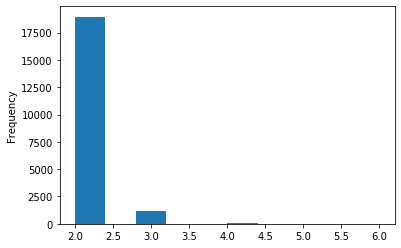

In [278]:
tesis.groupby('usuario')['canal'].nunique()[tesis.groupby('usuario')['canal'].nunique()!=1].plot(kind='hist')

In [279]:
# cantidad de sesiones por usuario
sum(tesis.groupby('usuario')['canal'].count()==1),round((sum(tesis.groupby('usuario')['canal'].count()==1)/len(tesis.usuario.unique())*100),2)

(620675, 86.91)

In [280]:
# cantidad de conversiones por usuario
pd.DataFrame(convertidores.groupby('usuario')['conversion'].sum().sort_values(ascending=False).head(20))

,conversion
usuario,
3244,33
9489,16
20397,16
7228,15
325866,15
335299,13
709,12
11823,12
2742,10


In [281]:
# usuarios que convierten
sum(convertidores.groupby('usuario')['canal'].nunique()!=1),sum(convertidores.groupby('usuario')['canal'].nunique()!=1)/len(convertidores.usuario.unique())

(1653, 0.16493713829574935)

In [282]:
# usuarios que convierten
sum(convertidores.groupby('usuario')['canal'].count()!=1),sum(convertidores.groupby('usuario')['canal'].count()!=1)/len(convertidores.usuario.unique())

(6895, 0.6879864298543205)

## PASO A PASO

In [310]:
# Top 20 de caminos que convirtieron
caminos_shapley.sort_values(by='conversion',ascending=False).head(20).reset_index().drop(columns=['index'])

,camino,conversion
0,Referral,4831
1,Organic Search,3002
2,Direct,2061
3,Paid Search,421
4,Direct>Referral,396
5,Organic Search>Paid Search,135
6,Display,134
7,Organic Search>Referral,109
8,Social,96
9,Direct>Organic Search,94


In [313]:
# chequear formato
data = formatear(tesis)

# calcular conversiones_totales
conversiones_totales = sum(data.conversion)

# obtener coaliciones posibles y gran coalicion de los n canales unicos
coaliciones, gran_coalicion = obtener_coaliciones(data)

# obtener caminos
caminos = obtener_caminos_shapley(data)

# agregar resultado al data frame de coaliciones
coaliciones.update(caminos)

# calcular el valor de shapley
shapley = calcular_shapley(coaliciones,gran_coalicion)

# dar formato
shapley = pd.DataFrame(shapley, index = gran_coalicion)


In [319]:
# atribuir conversiones totales segun valor de shapley
atribucion = pd.DataFrame(round(shapley.sum()/sum(shapley.sum())*conversiones_totales,2),columns=['shapley'])


In [320]:
atribucion

,shapley
(Other),1.09
Affiliates,9.85
Direct,2255.68
Display,146.66
Organic Search,3285.56
Paid Search,460.77
Referral,5287.32
Social,105.07


In [334]:
data = [[i.camino,i.conversion] for i in caminos_markov.itertuples()]

In [335]:
# agregar estados iniciales y finales
recorridos = ["(start)>"+i[0]+">(conversion)" if i[1] == 1 else "(start)>"+i[0]+">(null)" for i in data]

# armar las transiciones con pares de canales
transiciones = list(map(lambda x:list(zip(x[:],x[1:])),[i.split(">") for i in recorridos]))

# darle formato de inicio y fin
transiciones_formato = pd.DataFrame([j for i in transiciones for j in i],columns=['start','end'])

In [339]:
pd.DataFrame(recorridos,columns=['camino']).head(10)

,camino
0,(start)>(Other)>Organic Search>Organic Search>...
1,(start)>(Other)>(null)
2,(start)>(Other)>(Other)>Organic Search>(null)
3,(start)>(Other)>Paid Search>Organic Search>(null)
4,(start)>(Other)>(Other)>Referral>Referral>Orga...
5,(start)>(Other)>(Other)>(Other)>Direct>(null)
6,(start)>(Other)>Direct>(null)
7,(start)>(Other)>Paid Search>(null)
8,(start)>(Other)>(Other)>(Other)>Display>Displa...
9,(start)>(Other)>Organic Search>Organic Search>...


In [341]:
transiciones_formato.head(10)

,start,end
0,(start),(Other)
1,(Other),Organic Search
2,Organic Search,Organic Search
3,Organic Search,(null)
4,(start),(Other)
5,(Other),(null)
6,(start),(Other)
7,(Other),(Other)
8,(Other),Organic Search
9,Organic Search,(null)


In [342]:
# armar la matriz normalizada con las transiciones
matriz = pd.crosstab(index=transiciones_formato['start'],columns=transiciones_formato['end'], normalize = 'index', dropna = False)

# chequear si falta alguna columna y agregarla
for columna in ['(conversion)','(null)']:
    if columna not in matriz.columns:
        matriz.insert(0,columna,np.zeros(matriz.shape[0]))

# agregar start como posible final
matriz.insert(0,'(start)',np.zeros(matriz.shape[0]))

In [343]:
matriz

end,(start),(Other),(conversion),(null),Affiliates,Direct,Display,Organic Search,Paid Search,Referral,Social
start,,,,,,,,,,,
(Other),0.0,0.250000,0.008333,0.166667,0.008333,0.108333,0.108333,0.183333,0.033333,0.125000,0.008333
(start),0.0,0.000125,0.000000,0.000000,0.017286,0.153807,0.005193,0.415774,0.024461,0.089069,0.294286
Affiliates,0.0,0.000000,0.000549,0.771505,0.182893,0.000000,0.000000,0.043285,0.001768,0.000000,0.000000
Direct,0.0,0.000000,0.014410,0.709528,0.001657,0.225763,0.002363,0.017927,0.002860,0.021646,0.003845
Display,0.0,0.000000,0.022836,0.315394,0.000958,0.000000,0.335356,0.185564,0.054455,0.085436,0.000000
Organic Search,0.0,0.000000,0.009023,0.811281,0.000000,0.000000,0.000000,0.179696,0.000000,0.000000,0.000000
Paid Search,0.0,0.000000,0.018519,0.579365,0.000000,0.000000,0.000000,0.147319,0.254797,0.000000,0.000000
Referral,0.0,0.000000,0.050764,0.549114,0.006486,0.000000,0.000000,0.042237,0.003348,0.348051,0.000000
Social,0.0,0.000000,0.000460,0.930514,0.000155,0.000000,0.000323,0.004736,0.000575,0.002583,0.060654


In [345]:
# calcular conversion general y guardar
cr_general = calcular_markov(matriz)


In [347]:
cr_general

0.016044277580530914

In [356]:
# obtener el diciconario del removal effect de cada canal
removal_effect = calcular_removal_effect(matriz)

In [360]:
pd.DataFrame.from_dict(removal_effect,orient='index',columns = ['atribucion'])

,atribucion
(Other),0.000119
Affiliates,0.001455
Direct,0.195341
Display,0.017081
Organic Search,0.284800
Paid Search,0.042182
Referral,0.445045
Social,0.013977


In [368]:
tesis_modelos.set_index('canal')[['markov']]

,markov
canal,
(Other),1.3798
Affiliates,16.8120
Direct,2256.5751
Display,197.3198
Organic Search,3290.0101
Paid Search,487.2872
Referral,5141.1583
Social,161.4577


In [369]:
tesis_modelos.set_index('canal')[['first','last']]

,first,last
canal,,
(Other),5,1
Affiliates,12,9
Direct,2616,2061
Display,268,142
Organic Search,3271,3146
Paid Search,436,593
Referral,4848,5458
Social,96,142


In [389]:
first,last,linear = heuristic(tesis)

In [394]:
heuristicos = first.merge(last, right_index = True, left_index = True).merge(linear, right_index = True, left_index = True)

In [395]:
heuristicos

,first,last,linear
canal,,,
(Other),5,1,2.533333
Affiliates,12,9,10.500000
Direct,2616,2061,2333.450000
Display,268,142,207.400000
Organic Search,3271,3146,3214.066667
Paid Search,436,593,519.116667
Referral,4848,5458,5148.116667
Social,96,142,116.816667


## ERROR

In [283]:
def calcular_modelos(data):
    heuristico = heuristic(data)
    first = heuristico[0]
    last = heuristico[1]
    linear = heuristico[2]
    shapley = shapley_value(data)
    markov = markov_chain(data)
    modelos = [first, last, linear, shapley, markov]
    final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), modelos)
    return final

In [284]:
def error_ponderado(data,modelo):
    error_first = abs((data.loc[:,"first"] - data.loc[:,modelo])/data.loc[:,"first"]).mean(axis=0)
    error_last = abs((data.loc[:,"last"] - data.loc[:,modelo])/data.loc[:,"last"]).mean(axis=0)
    return error_first,error_last

In [285]:
def mse(data,modelo):
    mse_first = ((data.loc[:,"first"] - data.loc[:,modelo])**2).mean(axis=0)
    mse_last = ((data.loc[:,"last"] - data.loc[:,modelo])**2).mean(axis=0)
    return mse_first,mse_last

In [399]:
def euclidean(data,modelo):
    euclidean_first = np.sqrt(sum((data.loc[:,"first"] - data.loc[:,modelo])**2))
    euclidean_last = np.sqrt(sum((data.loc[:,"last"] - data.loc[:,modelo])**2))    
    return euclidean_first, euclidean_last

In [286]:
def minMax(data):
    minimo = data.min(axis=1)
    maximo = data.max(axis=1)
    data = (data.T - minimo)/(maximo - minimo)
    return data.T

In [287]:
#tesis_modelos = calcular_modelos(tesis)
tesis_modelos = pd.read_csv("tesis_modelos.csv")

In [413]:
tesis_modelos.set_index("canal").drop(columns=['first_last']).sort_values(by=['first'])

,first,last,linear,shapley,markov
canal,,,,,
(Other),5,1,2.5333,1.09,1.3798
Affiliates,12,9,10.5000,9.85,16.8120
Social,96,142,116.8167,105.07,161.4577
Display,268,142,207.4000,146.66,197.3198
Paid Search,436,593,519.1167,460.77,487.2872
Direct,2616,2061,2333.4500,2255.68,2256.5751
Organic Search,3271,3146,3214.0667,3285.56,3290.0101
Referral,4848,5458,5148.1167,5287.32,5141.1583


In [289]:
tesis_modelos["first_last"] = tesis_modelos[["first","last"]].mean(axis=1)

In [290]:
np.sqrt(mse(tesis_modelos,"markov"))

array([168.61067239, 147.50103455])

In [291]:
np.sqrt(mse(tesis_modelos,"shapley"))

array([205.6950663 , 114.77151345])

In [292]:
error_ponderado(tesis_modelos,"markov")

(0.29899135233201746, 0.2689237133835998)

In [293]:
error_ponderado(tesis_modelos,"shapley")

(0.22475325088268133, 0.10880102666147368)

In [294]:
np.sqrt(((tesis_modelos.loc[:,"first"] - tesis_modelos.loc[:,"markov"])**2).mean(axis=0))

168.61067238542466

In [410]:
distancia = []
modelos_evaluar = ["markov","shapley","linear"]
for i in modelos_evaluar:
    distancia.append(euclidean(tesis_modelos,i))
pd.DataFrame(distancia,index=modelos_evaluar,columns=["distancia_first","distancia_last"]).round(2)

,distancia_first,distancia_last
markov,476.90,417.20
shapley,581.79,324.62
linear,429.15,430.42


In [401]:
euclidean(tesis_modelos,"shapley")

(581.7935049482762, 324.6228617950375)

In [403]:
euclidean(tesis_modelos,"linear")

(429.14840346254334, 430.4235581313483)

## VARIANZA

In [295]:
def particiones(data,n):
    data = formatear(data)
    usuarios = data.usuario.unique()
    np.random.shuffle(usuarios)
    particiones = np.array_split(usuarios,n)
    return [data[data.usuario.isin(i)] for i in particiones]

In [376]:
def calcular_modelos(particiones):
    modelos_shapley = []
    modelos_markov = []
    modelos_first = []
    modelos_last = []
    modelos_linear = []
    
    for i in enumerate(particiones):
        modelos_shapley.append(shapley_value(i[1]).rename(columns=lambda x: x+str(i[0])))
        modelos_markov.append(markov_chain(i[1]).rename(columns=lambda x: x+str(i[0])))
        modelos_first.append(heuristic(i[1])[0].rename(columns=lambda x: x+str(i[0])))
        modelos_last.append(heuristic(i[1])[1].rename(columns=lambda x: x+str(i[0])))
        modelos_linear.append(heuristic(i[1])[2].rename(columns=lambda x: x+str(i[0])))
   
    modelos_shapley = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), modelos_shapley)
    modelos_markov = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), modelos_markov)
    modelos_first = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), modelos_first)
    modelos_last = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), modelos_last)
    modelos_linear = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True), modelos_linear)
    
    return modelos_shapley,modelos_markov,modelos_first,modelos_last,modelos_linear

In [377]:
tesis_particiones = calcular_modelos(particiones(tesis,10))

/home/tomasrene/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [378]:
tesis_particiones_shapley = tesis_particiones[0]
tesis_particiones_markov = tesis_particiones[1]
tesis_particiones_first = tesis_particiones[2]
tesis_particiones_last = tesis_particiones[3]
tesis_particiones_linear = tesis_particiones[4]

In [300]:
tesis_particiones_shapley = read_csv("tesis_particiones_shapley.csv")
tesis_particiones_markov = read_csv("tesis_particiones_markov.csv")
tesis_particiones_first = read_csv("tesis_particiones_first.csv")
tesis_particiones_last = read_csv("tesis_particiones_last.csv")
tesis_particiones_linear = read_csv("tesis_particiones_linear.csv")

In [385]:
nombre_modelos = ['shapley','markov','first','last','linear']

In [383]:
resultado_error = []
for i in tesis_particiones:
    resultado_error.append(i.std(axis=1).mean())

In [387]:
tesis_particiones_shapley

,shapley0,shapley1,shapley2,shapley3,shapley4,shapley5,shapley6,shapley7,shapley8,shapley9
(Other),0.00,0.00,1.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Affiliates,1.10,0.00,0.00,1.10,0.00,4.37,0.00,1.10,1.09,1.10
Direct,203.55,235.52,238.47,231.85,272.63,177.09,238.60,231.44,201.42,225.09
Display,9.90,15.13,11.98,20.98,9.85,15.30,13.13,30.71,8.74,11.04
Organic Search,301.47,289.54,333.20,326.79,364.60,313.73,333.82,333.45,343.11,346.46
Paid Search,37.41,45.38,49.00,48.58,53.65,50.28,42.68,46.07,44.64,43.03
Referral,500.77,563.96,523.76,542.08,512.41,536.73,537.39,533.08,563.21,473.34
Social,8.80,6.48,18.51,6.62,9.85,17.49,4.38,13.16,9.80,9.94


In [388]:
tesis_particiones_markov

,markov0,markov1,markov2,markov3,markov4,markov5,markov6,markov7,markov8,markov9
(Other),0.1128,0.0614,0.1720,0.0782,0.1462,0.1182,0.1398,0.1103,0.3106,0.1328
Affiliates,1.5975,0.7363,0.8805,1.6393,0.9416,4.6294,0.8698,1.8249,1.7528,1.9317
Direct,205.4273,237.5598,237.5090,230.0828,268.0325,182.8714,238.0122,230.7274,205.7107,220.6160
Display,14.3971,19.7640,16.6813,26.2937,15.8724,19.8329,17.4660,35.3866,15.9906,15.7901
Organic Search,296.7810,290.6730,338.1212,320.2095,368.3599,314.7513,332.5722,339.8790,342.5727,346.1705
Paid Search,41.7202,45.7041,52.1035,54.2448,54.8940,53.3126,43.2116,50.8899,46.0702,45.1187
Referral,488.9929,548.2588,507.7626,533.0187,500.1100,517.7234,527.1851,509.5877,543.0310,465.3140
Social,13.9712,13.2425,22.7700,12.4330,14.6435,21.7607,10.5433,20.5941,16.5614,14.9262


In [386]:
pd.DataFrame(resultado_error,index=nombre_modelos,columns=['desvio_estandar'])

,desvio_estandar
shapley,11.679198
markov,11.150231
first,15.965726
last,14.955431
linear,15.364880


# BORRADOR

In [ ]:
tesis_markov_modelos.plot(kind='bar')

In [ ]:
tesis_markov_modelos.sum(axis=1) - final_tesis.loc[:,"markov"]

In [ ]:
tesis_markov_modelos.std(axis=1)# / tesis_markov_modelos.mean(axis=1)

In [ ]:
minmax = minMax(tesis_markov_modelos)
#prueba2 = pd.DataFrame(scaler.fit_transform(tesis_markov_modelos.T).T,index=tesis_markov_modelos.index,columns=tesis_markov_modelos.columns)
minmax

In [ ]:
minmax.mean(axis=0).plot(kind='bar')

In [ ]:
sns.heatmap(minmax)

In [ ]:
escalado = pd.DataFrame(preprocessing.scale(tesis_markov_modelos,axis=1),index=tesis_markov_modelos.index,columns=tesis_markov_modelos.columns)
escalado

In [ ]:
sns.heatmap(escalado)

In [ ]:
sns.heatmap(pd.DataFrame(np.random.normal(0,1,(8,10))))